In [81]:
from plotting import imshow
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2

In [82]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [83]:
# RGB training data load
yuv_train_set = unpickle('yuv_train')

# Image names 
filenames = [f.decode('utf-8') for f in yuv_train_set[b'filenames']]

# Getting the images
yuv_images_data = yuv_train_set[b'data'].copy() 

In [84]:
def yuv_rgb(array):
    new_array = array.numpy().copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    return torch.tensor((new_array*255).astype(np.uint8)).permute(2, 0, 1)

In [85]:
class YUVImageClassificationDataset(Dataset):
    def __init__(self, filenames, images_data, bin_count=50):
        self.filenames = filenames # image name
        self.images_data = images_data # images data: data used to construct the images 
        self.bin_count = bin_count # number of bins used 
        self.bins = np.linspace(0, 1, bin_count)  # Bin edges
        # we are creating bins between 0 and 1 in order to have the values of u and v

    def __len__(self):
        return len(self.filenames)
    
    def bin_labels(self, values):
        return np.digitize(values, self.bins) -1 # Map values to bin indices
                                                   # This function takes values and assigns each value to a bin index
                                                   # based on self.bins. It returns the index starting from 0

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3,32,32)  # (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)

        # Channel shapes are (H,W)
        Y_channel = img[:, :, 0] / 255.0  # Normalize Y to [0, 1] for stability of the network 
        U_channel = img[:, :, 1] / 255.0   
        V_channel = img[:, :, 2] / 255.0

        # Binned shapes are (H,W)
        U_binned = self.bin_labels(U_channel)  # Discretize U 
        V_binned = self.bin_labels(V_channel)  # Discretize V
        
        # Expanded (1,H,W)
        Y_channel = np.expand_dims(Y_channel, axis=0)

        # Tensor shapes are the same as the array shapes
        Y_channel = torch.tensor(Y_channel, dtype=torch.float32) # transform into tensor to use pytorch 
        U_binned = torch.tensor(U_binned, dtype=torch.long)
        V_binned = torch.tensor(V_binned, dtype=torch.long)
       
        return Y_channel, U_binned, V_binned, self.filenames[idx]



### Creating a lookup table

In [86]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [87]:
# Loading the RGB images
dataset = YUVImageClassificationDataset(filenames=filenames, images_data=yuv_images_data)
train_loader = DataLoader(dataset, batch_size=8, shuffle = False)

tensor([ 89, 112,  51], dtype=torch.uint8)
Filename: bos_taurus_s_000507.png


C:\Users\adadi\AppData\Local\Temp\ipykernel_26120\3092592313.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)
c:\ProgramData\anaconda3\lib\site-packages\torch\_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\adadi\AppData\Local\Temp\ipykernel_26120\3092592313.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)


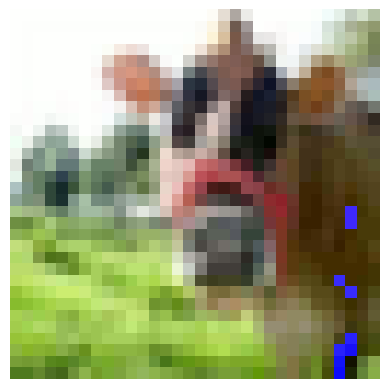

In [88]:
for Y_channel, U_binned, V_binned, fname in train_loader:
    
    U_target_rec = unbin_labels(U_binned.clone().detach())
    U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)

    V_target_rec = unbin_labels(V_binned.clone().detach())
    V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)
    
    reconstructed_img = torch.cat([Y_channel.cpu(),U_target_rec_tensor.cpu(),V_target_rec_tensor.cpu()],dim=1)

    image_yuv = reconstructed_img[0]  # Frist image of the batch (YUV)

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))
    print(rgb_output[:,30,30])

    print(f"Filename: {fname[0]}")

    imshow(rgb_output) 
    
    
    break

In [89]:
'''
# RGB training data load
train_set = unpickle('train')

# Image names 
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]

# Getting the images
images_data = train_set[b'data'].copy() 
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # image name
        self.images_data = images_data # image data
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3,32,32)  # (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)

       
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Normalization and transforming to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])
'''

"\n# RGB training data load\ntrain_set = unpickle('train')\n\n# Image names \nfilenames = [f.decode('utf-8') for f in train_set[b'filenames']]\n\n# Getting the images\nimages_data = train_set[b'data'].copy() \nclass CustomDataset(Dataset):\n    def __init__(self, filenames, images_data, transform=None):\n        self.filenames = filenames # image name\n        self.images_data = images_data # image data\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.filenames)\n\n    def __getitem__(self, idx):\n        # Creating image from the dataset\n        img_data = self.images_data[idx]\n        img = np.array(img_data, dtype=np.uint8).reshape(3,32,32)  # (C, H, W)\n        img = np.transpose(img, (1, 2, 0))  # (H, W, C)\n\n       \n        if self.transform:\n            img = self.transform(img)\n\n        return img, self.filenames[idx]\n\n# Normalization and transforming to a tensor\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n])\n"

In [90]:
'''
dataset = CustomDataset(filenames=filenames, images_data=images_data,transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)
for batch in train_loader:
    image_tensor, filename = batch  # Extract data from the batch
    for idx, image_rgb in enumerate(image_tensor):
        imh_rgb = image_rgb 
        imshow(imh_rgb)
        break
    break
    '''

'\ndataset = CustomDataset(filenames=filenames, images_data=images_data,transform=transform)\ntrain_loader = DataLoader(dataset, batch_size=32, shuffle = False)\nfor batch in train_loader:\n    image_tensor, filename = batch  # Extract data from the batch\n    for idx, image_rgb in enumerate(image_tensor):\n        imh_rgb = image_rgb \n        imshow(imh_rgb)\n        break\n    break\n    '

In [91]:
'''
# original - created
difference = imh_rgb -rgb_output
print("R difference max: ",torch.max(difference[0,:,:]),", min :",torch.min(difference[0,:,:]))
print("G difference max: ",torch.max(difference[1,:,:]),", min :",torch.min(difference[1,:,:]))
print("B difference max: ",torch.max(difference[2,:,:]),", min :",torch.min(difference[2,:,:]))
'''

'\n# original - created\ndifference = imh_rgb -rgb_output\nprint("R difference max: ",torch.max(difference[0,:,:]),", min :",torch.min(difference[0,:,:]))\nprint("G difference max: ",torch.max(difference[1,:,:]),", min :",torch.min(difference[1,:,:]))\nprint("B difference max: ",torch.max(difference[2,:,:]),", min :",torch.min(difference[2,:,:]))\n'

In [92]:
# ----- CLASSIFICATION CNN MODEL -----
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ClassificationCNN, self).__init__()
        
        # Initial Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Skip Connections
        self.skip0 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        
        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        
        # Output Layers for Classification
        self.output_U = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.output_V = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1_pooled = self.pool1(x1)
        
        x2 = self.conv2(x1_pooled)
        x2_pooled = self.pool2(x2)
        x2_pooled_padded = F.interpolate(x2_pooled, size=(32, 32), mode='bilinear', align_corners=False)

        x1_conv = self.skip0(x1)
        x2_padded = F.interpolate(x2, size=(32, 32), mode='bilinear', align_corners=False)
        el_wise = x1_conv + x2_padded
        
        # Concatenation layer
        x_concat = torch.cat([el_wise, x2_pooled_padded], dim=1) # necessitano solo stessa H e W

        # Final convolutional processing
        x_final = self.conv_final(x_concat)

        U_out = self.output_U(x_final)
        V_out = self.output_V(x_final)

        return U_out, V_out

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bin_count = 50
model = ClassificationCNN(bin_count).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [94]:
total_loss = []
# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, U_target, V_target, fname in train_loader:
        Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
        #print('U target: \n', U_target)

        optimizer.zero_grad()
        U_pred, V_pred = model(Y_channel)
        #print('U pred: \n',U_pred)

        loss_U = criterion(U_pred, U_target)
        loss_V = criterion(V_pred, V_target)
        loss = loss_U + loss_V

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), f"models/yuv_classification_{num_epochs}ep.pth")

KeyboardInterrupt: 

In [95]:
def converter(pred):
    softmax = nn.Softmax(dim = 1).to(device)
    probs = softmax(pred)
    _, ind = torch.topk(probs,1,1)
    return ind

In [96]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [101]:
model.load_state_dict(torch.load("yuv_classification_30ep.pth"))

C:\Users\adadi\AppData\Local\Temp\ipykernel_26120\1389814760.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("yuv_classification_30ep.pt

<All keys matched successfully>

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
Filename: bos_taurus_s_000507.png
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


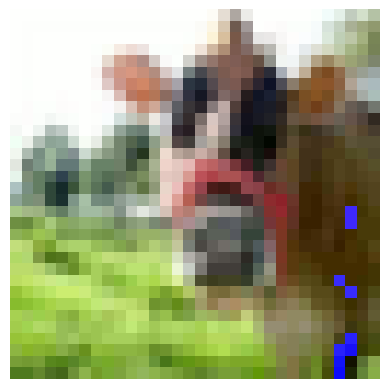

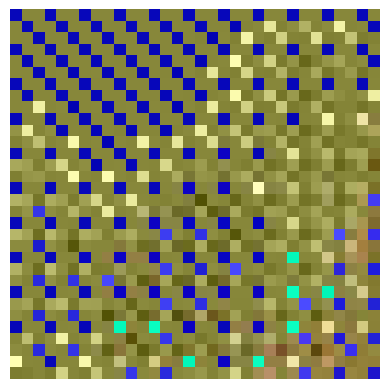

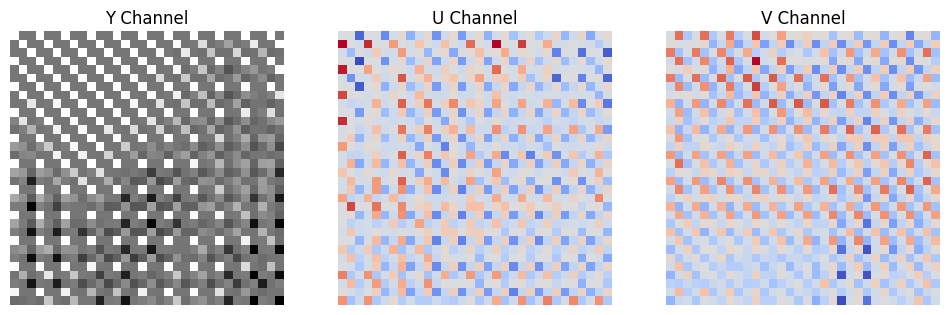

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
Filename: fog_s_000397.png
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


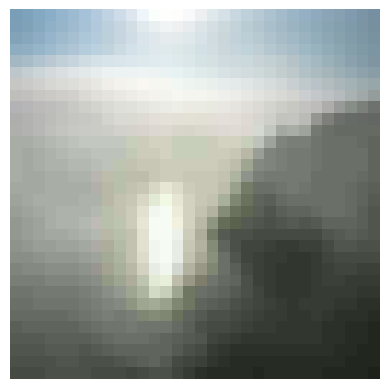

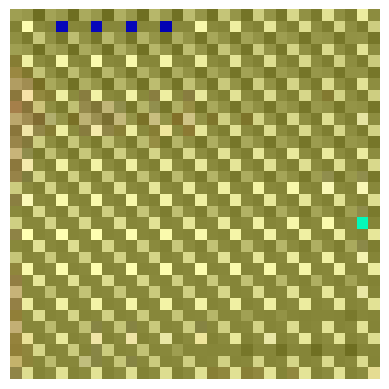

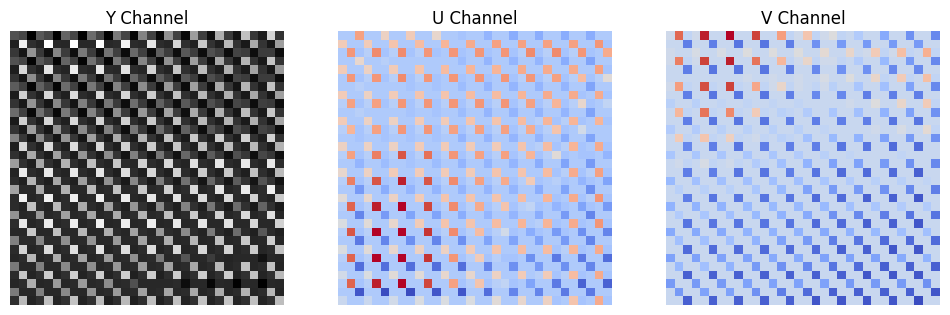

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
Filename: bike_s_000682.png
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


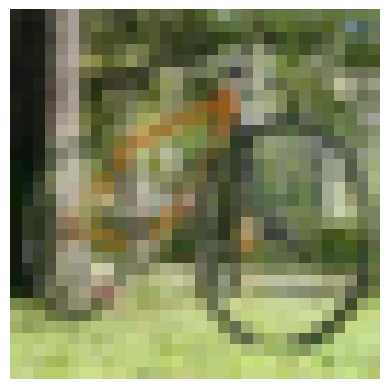

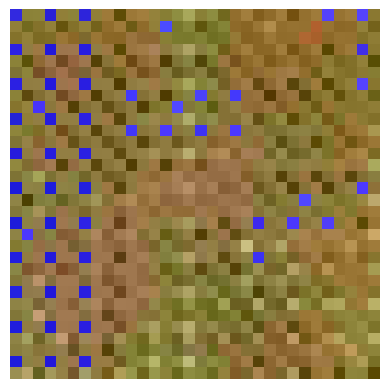

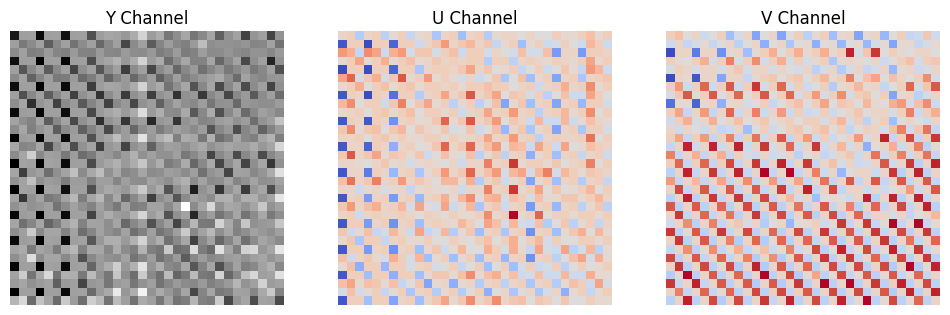

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
Filename: pine_s_001533.png
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


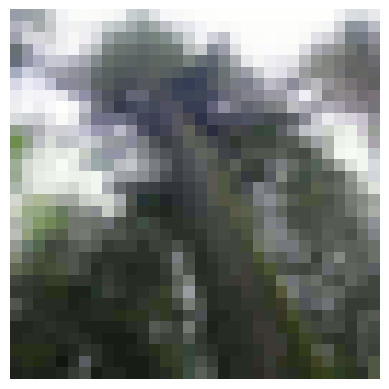

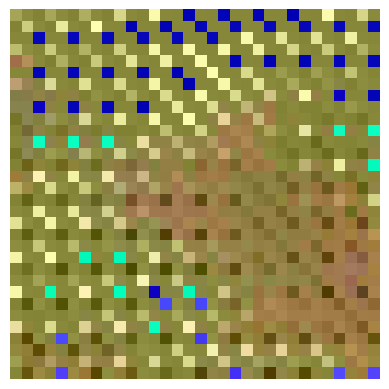

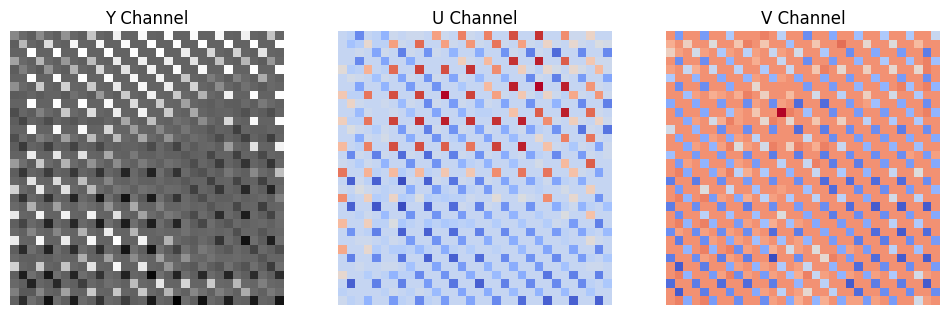

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
Filename: acer_saccharinum_s_000646.png
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


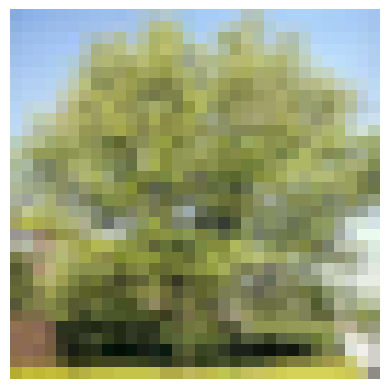

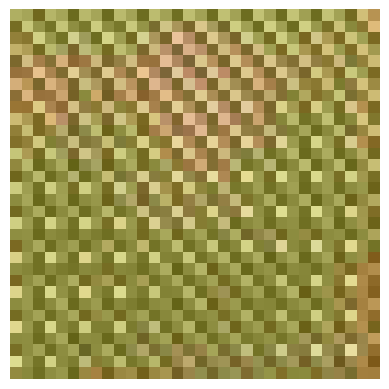

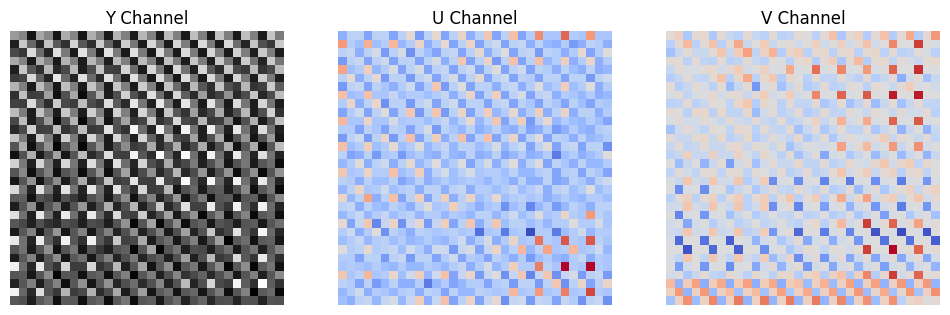

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
Filename: coluber_constrictor_s_000067.png
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


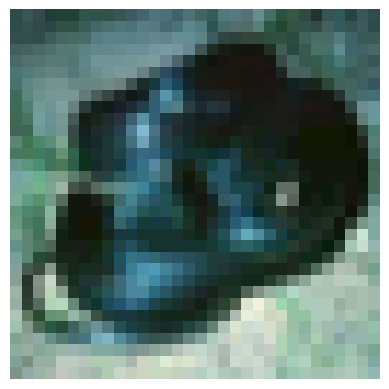

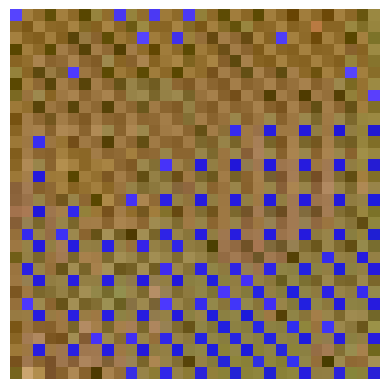

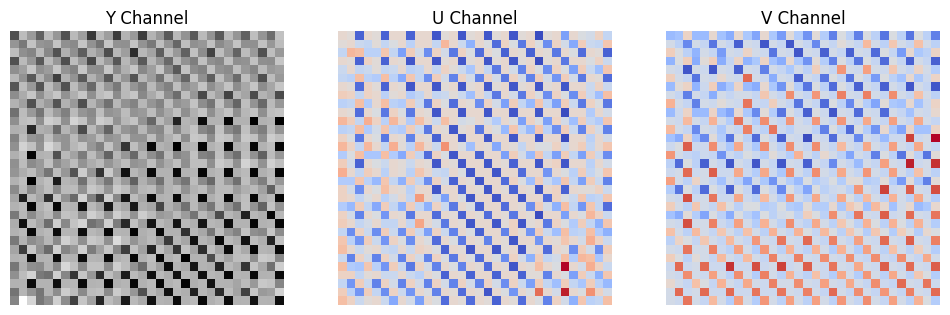

In [159]:
n = 0
for Y_channel, U_target, V_target, fname in train_loader:
    Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
    
    U_pred, V_pred = model(Y_channel)


    conv_pred_U = converter(U_pred.cpu())
    conv_pred_V = converter(V_pred.cpu())

    pred_U_rec = unbin_labels(conv_pred_U)[0, :, :]
    #pred_U_rec = pred_U_rec.unsqueeze(0)

    #pred_U_rec_tensor = torch.tensor(pred_U_rec, dtype=torch.float32).resize(8,1,32,32)
    pred_V_rec = unbin_labels(conv_pred_V )[0, :, :]
    #pred_V_rec = pred_V_rec.unsqueeze(0)
    #pred_V_rec_tensor = torch.tensor(pred_V_rec, dtype=torch.float32).resize(8,1,32,32)


    U_target_rec = unbin_labels(U_target)[0, :, :]
    U_target_rec = U_target_rec.unsqueeze(0)
    #U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)

    V_target_rec = unbin_labels(V_target)[0, :, :]
    V_target_rec = V_target_rec.unsqueeze(0)
    #V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)

    print(Y_channel[0, :, :, :].shape)
    print(pred_U_rec.shape)
    print(pred_V_rec.shape)

    reconstructed_pred = torch.cat([Y_channel[0, :, :, :],pred_U_rec,pred_V_rec],dim=0)
    

    reconstructed_img = torch.cat([Y_channel[0, :, :, :],U_target_rec,V_target_rec],dim=0)

    '''
    image_yuv = reconstructed_img[0].cpu()  # Frist image of the batch (YUV)
    

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))
    rgb_output_pred = yuv_rgb(image_yuv_pred.resize(32, 32,3))
    '''
    # Spostare tutti i tensori su CPU
    image_yuv_pred = reconstructed_pred.cpu()
    Y_channel = Y_channel.cpu()
    U_target_rec = U_target_rec.cpu()
    V_target_rec = V_target_rec.cpu()

    # Concatenare per ottenere un'immagine YUV
    image_yuv = torch.cat([Y_channel[0, :, :, :], U_target_rec, V_target_rec], dim=0)  # [3, 32, 32]


    print(f"Filename: {fname[0]}")

    print(reconstructed_pred.shape)

    print(image_yuv_pred.shape)

    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))
    rgb_output_pred = yuv_rgb(image_yuv_pred.permute(1, 2, 0))#.resize(32, 32,3))

    imshow(rgb_output) 
    imshow(rgb_output_pred) 

    Y_channel = Y_channel[0, 0, :, :].cpu().numpy()  # [32, 32]
    U_target = U_target_rec[0, :, :].cpu().numpy()   # [32, 32]
    V_target = V_target_rec[0, :, :].cpu().numpy()   # [32, 32]

# Creare la figura con 3 sottotrame per Y, U, V
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Mostrare ogni canale separatamente
    axes[0].imshow(Y_channel, cmap="gray")
    axes[0].set_title("Y Channel")

    axes[1].imshow(U_target, cmap="coolwarm")
    axes[1].set_title("U Channel")

    axes[2].imshow(V_target, cmap="coolwarm")
    axes[2].set_title("V Channel")

# Rimuovere gli assi
    for ax in axes:
        ax.axis("off")

    plt.show()

    n += 1

    if n == 6:
        break